In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Generating Autoregressive data for experiments

In [2]:
# 代码来源 : http://www.jessicayung.com/generating-autoregressive-data-for-experiments/
# 代码来源 : https://github.com/jessicayung/blog-code-snippets
class TimeSeriesData:
    def __init__(self, num_datapoints, test_size=0.2, max_t=20, num_prev=1,
                 noise_var=1):
        """
        Template class for generating time series data.
        :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
        """
        self.num_datapoints = num_datapoints
        self.test_size = test_size
        self.num_prev = num_prev
        self.max_t = max_t
        self.data = None
        self.noise_var = noise_var
        self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
        self.bayes_preds = np.copy(self.y)

        # Generate data and reshape data
        self.create_data()

        # Split into training and test sets
        self.train_test_split()

    def create_data(self):
        self.generate_data()
        self.reshape_data()

    def generate_data(self):
        """Generates data in self.y, may take as implicit input timesteps self.t.
        May also generate Bayes predictions."""
        raise NotImplementedError("Generate data method not implemented.")

    def reshape_data(self):
        self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
            self.num_datapoints)], (-1, self.num_prev))
        self.y = np.copy(self.y[self.num_prev:])
        self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

    def train_test_split(self):
        test_size = int(len(self.y) * self.test_size)
        self.data = [self.X_train, self.X_test, self.y_train,
                     self.y_test] = \
                    self.x[:-test_size], self.x[-test_size:], \
                    self.y[:-test_size], self.y[-test_size:]
        self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]

    def return_data(self):
        return self.data

    def return_train_test(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

class ARData(TimeSeriesData):
    """Class to generate autoregressive data."""

    def __init__(self, *args, coeffs=None, **kwargs):
        self.given_coeffs = coeffs
        super(ARData, self).__init__(*args, **kwargs)

        if coeffs is not None:
            self.num_prev = len(coeffs) - 1

    def generate_data(self):
        self.generate_coefficients()
        self.generate_initial_points()

        # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
        # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
        for i in range(self.num_datapoints+3*self.num_prev):
            # Generate y value if there was no noise
            # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
            self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
            # Add noise
            self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()

        # Cut first 20 points so dist is roughly stationary
        self.bayes_preds = self.bayes_preds[3*self.num_prev:]
        self.y = self.y[3*self.num_prev:]

    def generate_coefficients(self):
        if self.given_coeffs is not None:
            self.coeffs = self.given_coeffs
        else:
            filter_stable = False
            # Keep generating coefficients until we come across a set of coefficients
            # that correspond to stable poles
            while not filter_stable:
                true_theta = np.random.random(self.num_prev) - 0.5
                coefficients = np.append(1, -true_theta)
                # check if magnitude of all poles is less than one
                if np.max(np.abs(np.roots(coefficients))) < 1:
                    filter_stable = True
            self.coeffs = true_theta

    def generate_initial_points(self):
        # Initial datapoints distributed as N(0,1)
        self.y[:self.num_prev] = np.random.randn(self.num_prev)

    def noise(self):
        # Noise distributed as N(0, self.noise_var)
        return self.noise_var * np.random.randn()

# A set of coefficients that are stable (to produce replicable plots, experiments)
fixed_ar_coefficients = {2: [ 0.46152873, -0.29890739],
    5: [ 0.02519834, -0.24396899,  0.2785921,   0.14682383,  0.39390468],
                        10: [-0.10958935, -0.34564819,  0.3682048,   0.3134046,  -0.21553732,  0.34613629,
  0.41916508,  0.0165352,   0.14163503, -0.38844378],
                         20: [ 0.1937815,   0.01201026,  0.00464018, -0.21887467, -0.20113385, -0.02322278,
  0.34285319, -0.21069086,  0.06604683, -0.22377364,  0.11714593, -0.07122126,
 -0.16346554,  0.03174824,  0.308584,    0.06881604,  0.24840789, -0.32735569,
  0.21939492, 0.3996207 ]}

In [3]:
# --------------------
# Device configuration
# --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#####################
# Generate data
#####################
num_datapoints = 100
test_size = 0.2
input_size = 20
noise_var = 0

data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var, coeffs=fixed_ar_coefficients[input_size])

In [15]:
# data中包含X_train, Y_train, X_test, Y_test
print(data.X_train.shape,data.y_train.shape)

(80, 20) (80,)


In [16]:
print(data.X_test.shape,data.y_test.shape)

(20, 20) (20,)


In [5]:
X_train = torch.from_numpy(data.X_train).float().to(device)
X_test = torch.from_numpy(data.X_test).float().to(device)
y_train = torch.from_numpy(data.y_train).float().to(device)
y_test = torch.from_numpy(data.y_test).float().to(device)

In [57]:
X_train.shape

torch.Size([80, 20])

In [23]:
X_train.unsqueeze(1).shape

torch.Size([80, 1, 20])

In [6]:
# 使用slide window, window size=7
# 即返回 data=1-7 label=8; data=2-8 label=9
def create_dataset(X_data, y_data, look_back=1):
    length = X_data.size(0)
    for i in range(0,length-look_back):
        result = (X_data[i:(i+look_back),:],y_data[i+look_back])
        yield result

In [75]:
test_data = create_dataset(X_train,y_train, look_back=7)
for (i,j) in test_data:
    print(i.shape,j)

torch.Size([7, 20]) tensor(-0.1751, device='cuda:0')
torch.Size([7, 20]) tensor(-0.2223, device='cuda:0')
torch.Size([7, 20]) tensor(0.0469, device='cuda:0')
torch.Size([7, 20]) tensor(0.0818, device='cuda:0')
torch.Size([7, 20]) tensor(-0.0763, device='cuda:0')
torch.Size([7, 20]) tensor(0.1022, device='cuda:0')
torch.Size([7, 20]) tensor(0.0935, device='cuda:0')
torch.Size([7, 20]) tensor(-0.0546, device='cuda:0')
torch.Size([7, 20]) tensor(0.2455, device='cuda:0')
torch.Size([7, 20]) tensor(0.1946, device='cuda:0')
torch.Size([7, 20]) tensor(0.0043, device='cuda:0')
torch.Size([7, 20]) tensor(-0.0064, device='cuda:0')
torch.Size([7, 20]) tensor(-0.0950, device='cuda:0')
torch.Size([7, 20]) tensor(0.0167, device='cuda:0')
torch.Size([7, 20]) tensor(0.0708, device='cuda:0')
torch.Size([7, 20]) tensor(-0.2207, device='cuda:0')
torch.Size([7, 20]) tensor(-0.1005, device='cuda:0')
torch.Size([7, 20]) tensor(-0.0580, device='cuda:0')
torch.Size([7, 20]) tensor(-0.1583, device='cuda:0')
to

In [76]:
i

tensor([[ 0.1488,  0.0351, -0.0389,  0.0083, -0.0385, -0.0887, -0.0254, -0.0726,
         -0.1060, -0.0382, -0.0513,  0.0072,  0.0169, -0.0393,  0.0835,  0.1225,
          0.0279,  0.0752,  0.0503, -0.0096],
        [ 0.0351, -0.0389,  0.0083, -0.0385, -0.0887, -0.0254, -0.0726, -0.1060,
         -0.0382, -0.0513,  0.0072,  0.0169, -0.0393,  0.0835,  0.1225,  0.0279,
          0.0752,  0.0503, -0.0096,  0.0274],
        [-0.0389,  0.0083, -0.0385, -0.0887, -0.0254, -0.0726, -0.1060, -0.0382,
         -0.0513,  0.0072,  0.0169, -0.0393,  0.0835,  0.1225,  0.0279,  0.0752,
          0.0503, -0.0096,  0.0274,  0.0079],
        [ 0.0083, -0.0385, -0.0887, -0.0254, -0.0726, -0.1060, -0.0382, -0.0513,
          0.0072,  0.0169, -0.0393,  0.0835,  0.1225,  0.0279,  0.0752,  0.0503,
         -0.0096,  0.0274,  0.0079, -0.0469],
        [-0.0385, -0.0887, -0.0254, -0.0726, -0.1060, -0.0382, -0.0513,  0.0072,
          0.0169, -0.0393,  0.0835,  0.1225,  0.0279,  0.0752,  0.0503, -0.0096,
      

In [77]:
X_train[-2]

tensor([-0.0254, -0.0726, -0.1060, -0.0382, -0.0513,  0.0072,  0.0169, -0.0393,
         0.0835,  0.1225,  0.0279,  0.0752,  0.0503, -0.0096,  0.0274,  0.0079,
        -0.0469, -0.0320, -0.0749, -0.0983], device='cuda:0')

In [78]:
j

tensor(-0.0573, device='cuda:0')

In [79]:
y_train[-1]

tensor(-0.0573, device='cuda:0')

## Build Network

In [7]:
class TimeSeries(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(TimeSeries,self).__init__()
        self.input_dim = input_dim # 输入的特征的个数
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        # Defeine the GRU layer
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers, dropout=0.1)
        # Define the output layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        
    def init_hidden(self):
        # initialise hidden state
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
        # return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def forward(self,x):
        self.batch_size = x.size(1)
        self.hidden = self.init_hidden() # 初始化hidden state
        gru_out, self.hidden = self.gru(x, self.hidden)
        y_pred = self.fc(gru_out[-1])
        return y_pred

In [39]:
np.random.randn(10,1,20).shape

(10, 1, 20)

In [8]:
# 模型的测试
input_data = torch.from_numpy(np.random.randn(7,1,20)).float().to(device)
model = TimeSeries(input_dim=20, hidden_dim=20, batch_size=1, output_dim=1, num_layers=2).to(device)
model(input_data)

tensor([[-0.0021]], device='cuda:0', grad_fn=<AddmmBackward>)

## 模型的训练

In [9]:
# 模型的初始化
model = TimeSeries(input_dim=20, hidden_dim=28, batch_size=1, output_dim=1, num_layers=3).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 模型的训练
pre_output = y_train.clone()
num_epochs = 1000
hist = np.zeros(num_epochs) # 用来记录每一个epoch的误差

for t in range(num_epochs):
    test_data = create_dataset(X_train,y_train, look_back=7) # 这个要每次刷新
    loss = torch.tensor([0.0]).float().to(device)
    for num, (i,j) in enumerate(test_data):
        optimizer.zero_grad()
        # reset hidden states
        model.hidden = model.init_hidden()
        # forward
        output = model(i.unsqueeze(1))
        pre_output[num+7]=output
        # backward
        loss = loss + criterion(output, j)
    loss.backward()
    # optimize
    optimizer.step()
    # 打印与记录误差
    if t%10 == 0:
        print("Epoch:{:0>4d}, MSE:{:<10.9f}".format(t,loss.item()))
        print('============')
    hist[t] = loss.item()

Epoch:0000, MSE:8.438955307
Epoch:0010, MSE:2.617796659
Epoch:0020, MSE:2.100596189
Epoch:0030, MSE:1.656640410
Epoch:0040, MSE:1.297698498
Epoch:0050, MSE:1.072669864
Epoch:0060, MSE:0.853107750
Epoch:0070, MSE:0.660168946
Epoch:0080, MSE:0.491784811
Epoch:0090, MSE:0.531620502
Epoch:0100, MSE:0.495098591
Epoch:0110, MSE:0.488277167
Epoch:0120, MSE:0.438852519
Epoch:0130, MSE:0.408718497
Epoch:0140, MSE:0.403583318
Epoch:0150, MSE:0.383323967
Epoch:0160, MSE:0.459906161
Epoch:0170, MSE:0.346215844
Epoch:0180, MSE:0.334014773
Epoch:0190, MSE:0.295782954
Epoch:0200, MSE:0.271336615
Epoch:0210, MSE:0.193765327
Epoch:0220, MSE:0.155365109
Epoch:0230, MSE:0.131595090
Epoch:0240, MSE:0.134911284
Epoch:0250, MSE:0.123327047
Epoch:0260, MSE:0.089595281
Epoch:0270, MSE:0.080776535
Epoch:0280, MSE:0.065318339
Epoch:0290, MSE:0.062139522
Epoch:0300, MSE:0.052231308
Epoch:0310, MSE:0.062196679
Epoch:0320, MSE:0.048043706
Epoch:0330, MSE:0.042937677
Epoch:0340, MSE:0.080768086
Epoch:0350, MSE:0.05

## 结果的可视化

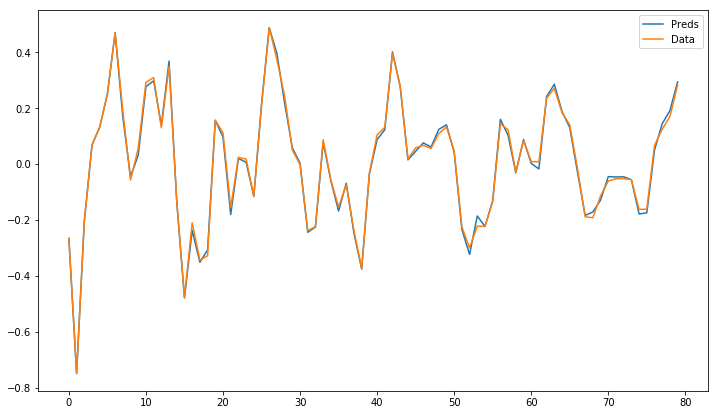

In [10]:
# 打印预测和实际
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)

ax.plot(pre_output.cpu().detach().numpy(), label="Preds")
ax.plot(y_train.cpu().detach().numpy(), label="Data")
ax.legend()

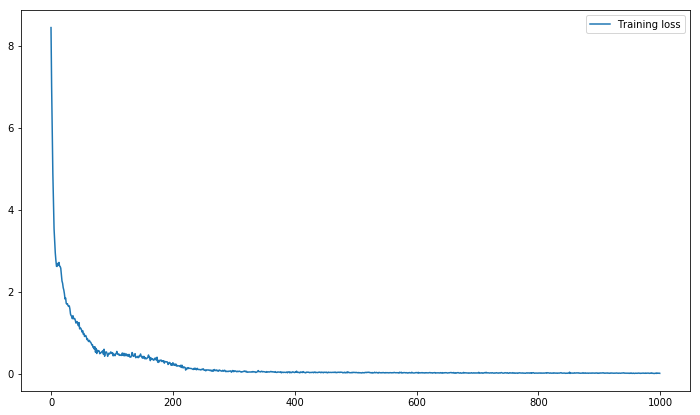

In [11]:
# 打印Loss
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)

ax.plot(hist, label="Training loss")
ax.legend()